In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

# Image Preparation

The following image preparation was taken almost verbatim from another excellent kernel of the TGS Salt Identification challenge: https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics. I take no credit for it.  

In [2]:
# Set some parameters# Set s 
im_width = 128
im_height = 128
im_chan = 1
path_train = './external/salt/train'
path_test = './external/salt/test'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")

In [3]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

/home/kan/anaconda3/envs/sfa-init/lib/python3.10/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


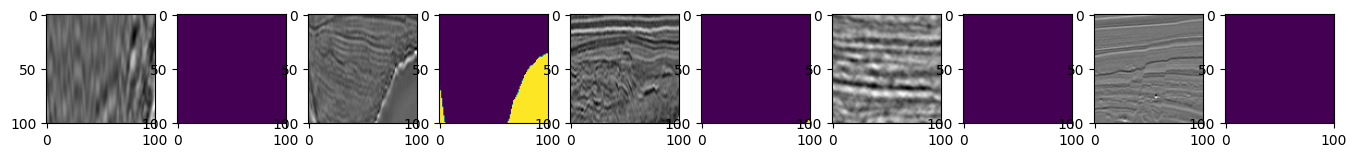

In [4]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_path_images + "/" + img_name + '.png')
    img_mask = imread(train_path_masks + "/" + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [5]:
train_ids = next(os.walk(train_path_images))[2]
test_ids = next(os.walk(test_path_images))[2]

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


/tmp/ipykernel_117594/598603007.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/4000 [00:00<?, ?it/s]

Done!


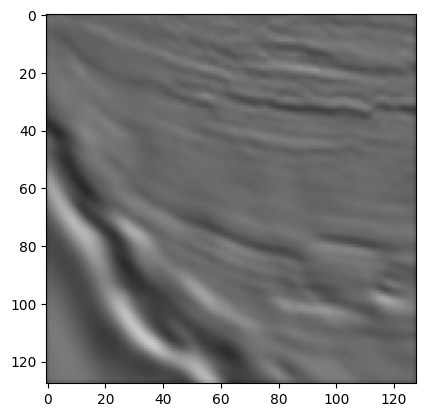

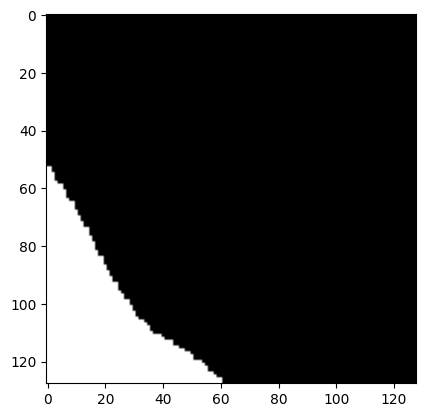

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Prepare Images for Pytorch

The following is what allows us to easily use our with Pytorch. We create a class with the following methods which then allows us to use a DataLoader.

In [8]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [9]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [10]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

We set a random seed for reproducibility.

In [11]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [12]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/10
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]

You may need to tweak your batch_size based on how much memory you have on your GPU.

In [13]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
salt_ID_dataset_val = saltIDDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)